<a href="https://colab.research.google.com/github/apriilbee/SIT719/blob/master/5_2HD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cyber Attack Classification Report**

SIT719 End-to-End Cybersecurity Analytics

# Project Setup

In [ ]:
# Import Necessary Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay, zero_one_loss, precision_recall_fscore_support

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

np.random.seed(224009373)

## Dataset 1

### Load Dataset

In [ ]:
train_url = 'https://raw.githubusercontent.com/adnandeakin/SIT719_Improved/master/data/Week_5_NSL-KDD-Dataset/KDDTrain%2B.txt'
test_url = 'https://raw.githubusercontent.com/adnandeakin/SIT719_Improved/master/data/Week_5_NSL-KDD-Dataset/KDDTest%2B.txt'
attack_types_url = 'https://raw.githubusercontent.com/adnandeakin/SIT719_Improved/master/data/Week_5_NSL-KDD-Dataset/training_attack_types.txt'


train_data = pd.read_csv(train_url, header=None)
test_data = pd.read_csv(test_url, header=None)

print(f"Training Data Shape: {train_data.shape}")
print(f"Testing Data Shape: {test_data.shape}")

# Drop last column (difficulty level)
train_data = train_data.iloc[:, :-1]
test_data = test_data.iloc[:, :-1]

Training Data Shape: (125973, 43)
Testing Data Shape: (22544, 43)


### Label Dataset Columns

In [ ]:
feature_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
]

train_data.columns = feature_names + ['label']
test_data.columns = feature_names + ['label']

# Show a few rows
train_data.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune
6,0,tcp,private,S0,0,0,0,0,0,0,...,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
7,0,tcp,private,S0,0,0,0,0,0,0,...,15,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,23,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
9,0,tcp,private,S0,0,0,0,0,0,0,...,13,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune


### Map Attack Names to Categories

In [ ]:
import requests

attack_mapping = {}
response = requests.get(attack_types_url)
for line in response.text.strip().split('\n'):
    attack, category = line.strip().split()
    attack_mapping[attack] = category

attack_mapping['normal'] = 'normal'

print("Unique labels BEFORE mapping:")
print(train_data['label'].unique())

train_data['label'] = train_data['label'].apply(lambda x: attack_mapping.get(x.strip().lower(), 'normal'))
test_data['label'] = test_data['label'].apply(lambda x: attack_mapping.get(x.strip().lower(), 'normal'))

print("\nUnique labels AFTER mapping:")
print(train_data['label'].unique())

Unique labels BEFORE mapping:
['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land'
 'loadmodule' 'spy' 'perl']

Unique labels AFTER mapping:
['normal' 'dos' 'r2l' 'probe' 'u2r']


### Preprocessing

In [ ]:
# Encoding categorical features

categorical_cols = ['protocol_type', 'service', 'flag']

encoder = LabelEncoder()
for col in categorical_cols:
    train_data[col] = encoder.fit_transform(train_data[col])
    test_data[col] = encoder.transform(test_data[col])

label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['label'])
test_data['label'] = label_encoder.transform(test_data['label'])

print("\nEncoded Labels Mapping:")
for index, class_label in enumerate(label_encoder.classes_):
    print(f"{index} -> {class_label}")


Encoded Labels Mapping:
0 -> dos
1 -> normal
2 -> probe
3 -> r2l
4 -> u2r


In [ ]:
# Split Train and Test Set to Features and Labels

X_train = train_data.drop(['label'], axis=1)
y_train = train_data['label']
X_test = test_data.drop(['label'], axis=1)
y_test = test_data['label']

In [ ]:
# Feature Scaling for SVM and kNN

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

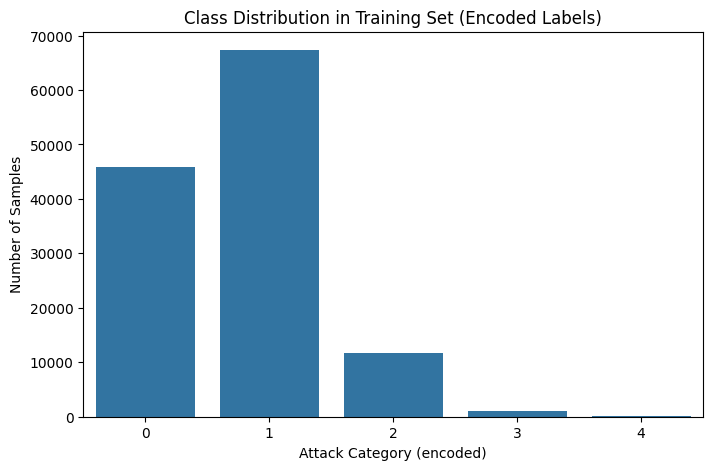

In [ ]:
# Plot Class Distribution

plt.figure(figsize=(8, 5))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set (Encoded Labels)")
plt.xlabel("Attack Category (encoded)")
plt.ylabel("Number of Samples")
plt.show()


### Train Models

#### Decision Tree
This model is adapted from SIT719 Repository (Sample)

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      7636
           1       0.70      0.97      0.81      9711
           2       0.63      0.62      0.62      2423
           3       0.95      0.14      0.25      2574
           4       0.57      0.06      0.11       200

    accuracy                           0.77     22544
   macro avg       0.76      0.52      0.53     22544
weighted avg       0.80      0.77      0.74     22544



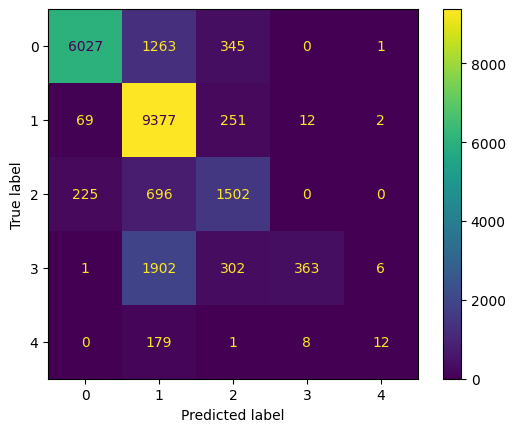

In [ ]:
dt_model = DecisionTreeClassifier(random_state=17)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

print(classification_report(y_test, dt_pred))
ConfusionMatrixDisplay.from_estimator(dt_model, X_test, y_test)
plt.show()

#### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.96      0.77      0.86      7636
           1       0.65      0.97      0.78      9711
           2       0.86      0.65      0.74      2423
           3       0.97      0.03      0.05      2574
           4       0.75      0.01      0.03       200

    accuracy                           0.75     22544
   macro avg       0.84      0.49      0.49     22544
weighted avg       0.82      0.75      0.71     22544



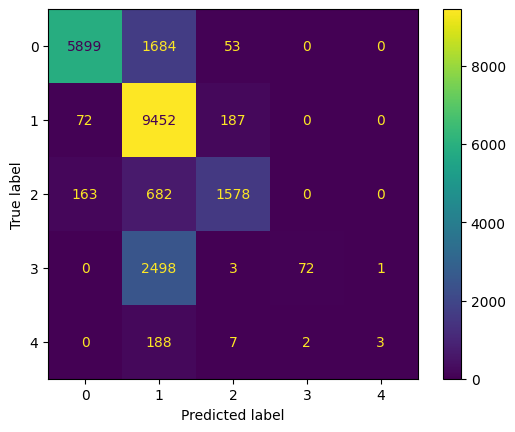

In [ ]:
rf_model = RandomForestClassifier(random_state=17)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print(classification_report(y_test, rf_pred))
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
plt.show()

#### Support Vector Machine

              precision    recall  f1-score   support

           0       0.96      0.74      0.83      7636
           1       0.65      0.98      0.78      9711
           2       0.87      0.66      0.75      2423
           3       0.87      0.03      0.07      2574
           4       0.80      0.08      0.15       200

    accuracy                           0.75     22544
   macro avg       0.83      0.50      0.52     22544
weighted avg       0.80      0.75      0.71     22544



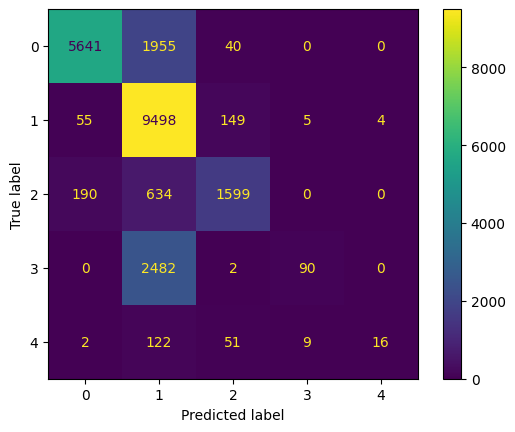

In [ ]:
svm_model = SVC(kernel='poly', random_state=17)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)

print(classification_report(y_test, svm_pred))
ConfusionMatrixDisplay.from_estimator(svm_model, X_test_scaled, y_test)
plt.show()

#### k-Nearest Neighbors (kNN)

              precision    recall  f1-score   support

           0       0.96      0.74      0.84      7636
           1       0.65      0.98      0.78      9711
           2       0.82      0.68      0.75      2423
           3       0.90      0.03      0.05      2574
           4       0.62      0.08      0.14       200

    accuracy                           0.75     22544
   macro avg       0.79      0.50      0.51     22544
weighted avg       0.80      0.75      0.71     22544



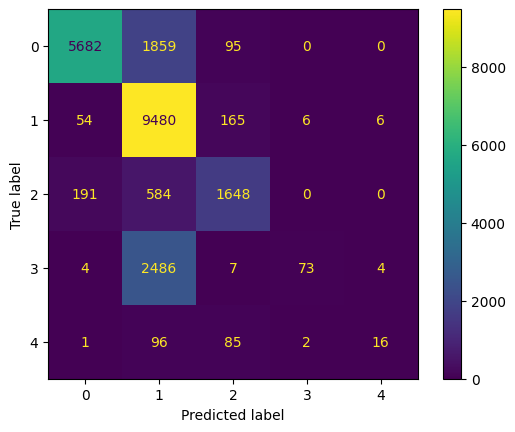

In [ ]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)

print(classification_report(y_test, knn_pred))
ConfusionMatrixDisplay.from_estimator(knn_model, X_test_scaled, y_test)
plt.show()

#### Naive Bayes

              precision    recall  f1-score   support

           0       0.33      0.83      0.47      7636
           1       0.22      0.03      0.06      9711
           2       0.00      0.00      0.00      2423
           3       0.00      0.00      0.00      2574
           4       0.01      0.06      0.01       200

    accuracy                           0.29     22544
   macro avg       0.11      0.18      0.11     22544
weighted avg       0.21      0.29      0.18     22544



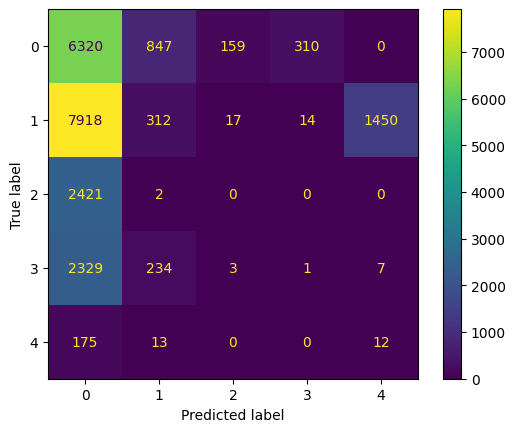

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

print(classification_report(y_test, nb_pred))
ConfusionMatrixDisplay.from_estimator(nb_model, X_test, y_test)
plt.show()

#### Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      7636
           1       0.66      0.98      0.79      9711
           2       0.84      0.75      0.79      2423
           3       0.41      0.00      0.01      2574
           4       0.81      0.07      0.12       200

    accuracy                           0.76     22544
   macro avg       0.74      0.51      0.51     22544
weighted avg       0.76      0.76      0.72     22544



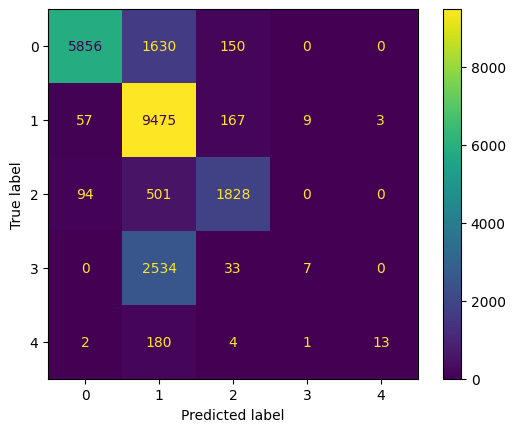

In [ ]:
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

print(classification_report(y_test, lr_pred))
ConfusionMatrixDisplay.from_estimator(lr_model, X_test_scaled, y_test)
plt.show()

### Evaluation Report

#### Per-Class Performance

In [ ]:
model_preds = [
    ('Decision Tree', dt_pred),
    ('Random Forest', rf_pred),
    ('SVM', svm_pred),
    ('kNN', knn_pred),
    ('Naive Bayes', nb_pred),
    ('Logistic Regression', lr_pred)
]

attack_classes = ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']

from sklearn.metrics import precision_recall_fscore_support

# Loop through each model
for model_name, preds in model_preds:
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        y_test, preds, labels=[0,1,2,3,4], zero_division=0
    )
    model_table = pd.DataFrame({
        'Attack Class': attack_classes,
        'Precision (%)': np.round(precision * 100, 2),
        'Recall (%)': np.round(recall * 100, 2),
        'F1-Score (%)': np.round(f1_score * 100, 2)
    })

    print(f"\n<<<< {model_name} >>>>\n")
    display(model_table)
    print("\n")


<<<< Decision Tree >>>>



,Attack Class,Precision (%),Recall (%),F1-Score (%)
0,DoS,95.33,78.93,86.36
1,Normal,69.89,96.56,81.09
2,Probe,62.56,61.99,62.27
3,R2L,94.78,14.10,24.55
4,U2R,57.14,6.00,10.86





<<<< Random Forest >>>>



,Attack Class,Precision (%),Recall (%),F1-Score (%)
0,DoS,96.17,77.25,85.68
1,Normal,65.17,97.33,78.07
2,Probe,86.32,65.13,74.24
3,R2L,97.30,2.80,5.44
4,U2R,75.00,1.50,2.94





<<<< SVM >>>>



,Attack Class,Precision (%),Recall (%),F1-Score (%)
0,DoS,95.81,73.87,83.42
1,Normal,64.65,97.81,77.85
2,Probe,86.85,65.99,75.00
3,R2L,86.54,3.50,6.72
4,U2R,80.00,8.00,14.55





<<<< kNN >>>>



,Attack Class,Precision (%),Recall (%),F1-Score (%)
0,DoS,95.79,74.41,83.76
1,Normal,65.36,97.62,78.30
2,Probe,82.40,68.01,74.52
3,R2L,90.12,2.84,5.50
4,U2R,61.54,8.00,14.16





<<<< Naive Bayes >>>>



,Attack Class,Precision (%),Recall (%),F1-Score (%)
0,DoS,32.98,82.77,47.17
1,Normal,22.16,3.21,5.61
2,Probe,0.00,0.00,0.00
3,R2L,0.31,0.04,0.07
4,U2R,0.82,6.00,1.44





<<<< Logistic Regression >>>>



,Attack Class,Precision (%),Recall (%),F1-Score (%)
0,DoS,97.45,76.69,85.83
1,Normal,66.17,97.57,78.86
2,Probe,83.78,75.44,79.39
3,R2L,41.18,0.27,0.54
4,U2R,81.25,6.50,12.04


In [ ]:
import pandas as pd
import plotly.express as px

# Data: summarize manually based on your table
f1_scores = pd.DataFrame({
    'Attack Class': ['DoS', 'Normal', 'Probe', 'R2L', 'U2R'],
    'Decision Tree': [86.36, 81.09, 62.27, 24.55, 10.86],
    'Random Forest': [85.68, 78.07, 74.24, 5.44, 2.94],
    'SVM': [83.42, 77.85, 75.00, 6.72, 14.55],
    'kNN': [83.76, 78.30, 74.52, 5.50, 14.16],
    'Naive Bayes': [47.17, 5.61, 0.00, 0.07, 1.44],
    'Logistic Regression': [85.83, 78.86, 79.39, 0.54, 12.04]
})

# Same f1_scores data
f1_scores.set_index('Attack Class', inplace=True)

fig = px.imshow(
    f1_scores.T,  # transpose so models are rows
    color_continuous_scale='Blues',
    text_auto=True,
    aspect="auto",
    title="Heatmap of F1-Scores Across Models and Attack Classes"
)

fig.update_layout(
    title_x=0.5,
    xaxis_title="Attack Class",
    yaxis_title="Model"
)

fig.show()


#### Per-Model Overall Performance

In [ ]:
overall_results = []

for model_name, preds in model_preds:
    overall_results.append({
        'Algorithm': model_name,
        'Accuracy (%)': round(accuracy_score(y_test, preds) * 100, 2),
        'Precision (%)': round(precision_score(y_test, preds, average='macro', zero_division=0) * 100, 2),
        'Recall (%)': round(recall_score(y_test, preds, average='macro', zero_division=0) * 100, 2),
        'F1-Score (%)': round(f1_score(y_test, preds, average='macro', zero_division=0) * 100, 2)
    })

# Create and display overall summary
overall_summary = pd.DataFrame(overall_results)
print("\n<<<< Overall Model Performance Summary >>>>")
display(overall_summary)


<<<< Overall Model Performance Summary >>>>


,Algorithm,Accuracy (%),Precision (%),Recall (%),F1-Score (%)
0,Decision Tree,76.65,75.94,51.52,53.03
1,Random Forest,75.43,83.99,48.80,49.27
2,SVM,74.72,82.77,49.83,51.51
3,kNN,74.96,79.04,50.18,51.25
4,Naive Bayes,29.48,11.25,18.40,10.86
5,Logistic Regression,76.20,73.96,51.29,51.33


In [ ]:
import plotly.express as px

# Create interactive bar plot
fig = px.bar(
    overall_summary,
    x='Algorithm',
    y='Accuracy (%)',
    title='Accuracy Comparison Across Algorithms',
    text='Accuracy (%)',
    range_y=[20, 80]  # y-axis from 20 to 80
)

# Customize the layout
fig.update_layout(
    yaxis=dict(dtick=5),  # y-tick every 5%
    xaxis_title='Algorithm',
    yaxis_title='Accuracy (%)',
    title_x=0.5,  # Center the title
    bargap=0.4
)

# Show interactive plot
fig.show()


#### Comparison with Benchmark Data

In [ ]:
import pandas as pd
import plotly.express as px

comparison_data = pd.DataFrame({
    'Algorithm': ['Decision Tree', 'Random Forest', 'kNN', 'Logistic Regression', 'SVM'],
    'This Study\'s Accuracy (%)': [76.65, 75.43, 74.96, 76.20, 74.72],
    'Benchmark Accuracy (%)': [79.71, 76.64, 75.51, 73.58, 74.09]
})

comparison_data_melted = comparison_data.melt(
    id_vars='Algorithm',
    var_name='Source',
    value_name='Accuracy (%)'
)

fig = px.bar(
    comparison_data_melted,
    x='Algorithm',
    y='Accuracy (%)',
    color='Source',
    barmode='group',
    text='Accuracy (%)',
    title='Comparison of Model Accuracy: This Study vs. Benchmark (NSL-KDD Dataset)',
    height=500
)

fig.update_layout(
    yaxis=dict(dtick=5, range=[60, 85]),
    xaxis_title='Algorithm',
    yaxis_title='Accuracy (%)',
    title_x=0.5,
    bargap=0.3,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    ),
    margin=dict(t=80, b=100)
)

fig.update_traces(textposition='outside')

fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# The comparison metrics between this study and the benchmark results were manually
# input for visualization purposes. This approach was taken to save time and
# avoid re-running all model evaluations, as the chart was added at a later stage of the project.

# 1. Prepare Data
comparison_metrics = pd.DataFrame({
    'Algorithm': ['Decision Tree', 'Random Forest', 'SVM', 'kNN', 'Logistic Regression'],
    'This Study Precision (%)': [75.94, 83.99, 82.77, 79.04, 73.96],
    'Benchmark Precision (%)': [83.51, 81.85, 80.91, 80.97, 74.65],
    'This Study Recall (%)': [51.52, 48.80, 49.83, 50.18, 51.29],
    'Benchmark Recall (%)': [79.72, 76.64, 74.09, 75.51, 73.58],
    'This Study F1-Score (%)': [53.03, 49.27, 51.51, 51.25, 51.33],
    'Benchmark F1-Score (%)': [77.31, 72.17, 70.38, 71.41, 69.13]
})

# 2. Create separate charts

# --- Precision Comparison ---
precision_data = comparison_metrics[['Algorithm', 'This Study Precision (%)', 'Benchmark Precision (%)']].melt(
    id_vars='Algorithm',
    var_name='Source',
    value_name='Precision (%)'
)

fig_precision = px.bar(
    precision_data,
    x='Algorithm',
    y='Precision (%)',
    color='Source',
    barmode='group',
    text='Precision (%)',
    title="Comparison of Precision: This Study vs. Benchmark (NSL-KDD Dataset)",
    height=500
)

fig_precision.update_layout(
    yaxis=dict(dtick=10, range=[0, 100]),
    title_x=0.5,
    bargap=0.3,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    )
)

fig_precision.update_traces(textposition='outside')
fig_precision.show()

# --- Recall Comparison ---
recall_data = comparison_metrics[['Algorithm', 'This Study Recall (%)', 'Benchmark Recall (%)']].melt(
    id_vars='Algorithm',
    var_name='Source',
    value_name='Recall (%)'
)

fig_recall = px.bar(
    recall_data,
    x='Algorithm',
    y='Recall (%)',
    color='Source',
    barmode='group',
    text='Recall (%)',
    title="Comparison of Recall: This Study vs. Benchmark (NSL-KDD Dataset)",
    height=500
)

fig_recall.update_layout(
    yaxis=dict(dtick=10, range=[0, 100]),
    title_x=0.5,
    bargap=0.3,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    )
)

fig_recall.update_traces(textposition='outside')
fig_recall.show()

# --- F1-Score Comparison ---
f1_data = comparison_metrics[['Algorithm', 'This Study F1-Score (%)', 'Benchmark F1-Score (%)']].melt(
    id_vars='Algorithm',
    var_name='Source',
    value_name='F1-Score (%)'
)

fig_f1 = px.bar(
    f1_data,
    x='Algorithm',
    y='F1-Score (%)',
    color='Source',
    barmode='group',
    text='F1-Score (%)',
    title="Comparison of F1-Score: This Study vs. Benchmark (NSL-KDD Dataset)",
    height=500
)

fig_f1.update_layout(
    yaxis=dict(dtick=10, range=[0, 100]),
    title_x=0.5,
    bargap=0.3,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    )
)

fig_f1.update_traces(textposition='outside')
fig_f1.show()


## Dataset 2

### Load Dataset

In [ ]:
ton_iot_url = 'https://raw.githubusercontent.com/apriilbee/SIT719/master/5.2DHD/Processed_Combined_IoT_dataset.csv'
ton_iot_data = pd.read_csv(ton_iot_url)

print(f"TON IoT Data Shape: {ton_iot_data.shape}")
ton_iot_data.head(10)

TON IoT Data Shape: (401119, 18)


,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,current_temperature,door_state,fridge_temperature,humidity,latitude,light_status,longitude,motion_status,pressure,sphone_signal,temp_condition,temperature,thermostat_status,label
0,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.930769,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.2,0.517307,1,0
1,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.588462,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.2,0.517307,1,0
2,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.076923,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.8,0.517307,1,0
3,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.292308,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.8,0.517307,1,0
4,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.746154,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.2,0.517307,1,0
5,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.307692,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.8,0.517307,1,0
6,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.819231,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.2,0.517307,1,0
7,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.153846,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.8,0.517307,1,0
8,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.076923,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.8,0.517307,1,0
9,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.457692,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.2,0.517307,1,0


### Preprocessing and Splitting


In [ ]:
ton_iot_X = ton_iot_data.drop('label', axis=1)
ton_iot_y = ton_iot_data['label']

# Split 70% training, 30% testing
from sklearn.model_selection import train_test_split

ton_iot_X_train, ton_iot_X_test, ton_iot_y_train, ton_iot_y_test = train_test_split(
    ton_iot_X, ton_iot_y, test_size=0.3, random_state=17, stratify=ton_iot_y
)

In [ ]:
# Standard Scaling
ton_iot_scaler = StandardScaler()
ton_iot_X_train_scaled = ton_iot_scaler.fit_transform(ton_iot_X_train)
ton_iot_X_test_scaled = ton_iot_scaler.transform(ton_iot_X_test)

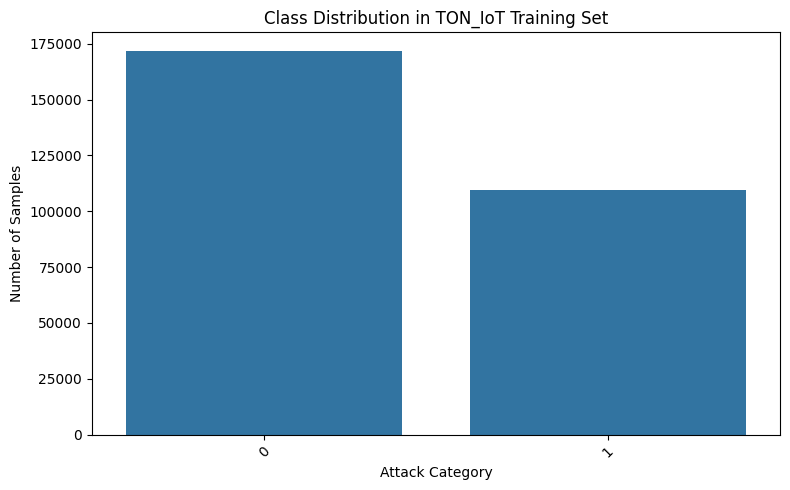

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x=ton_iot_y_train)
plt.title("Class Distribution in TON_IoT Training Set")
plt.xlabel("Attack Category")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Train Models

#### Decision Tree

              precision    recall  f1-score   support

           0       0.85      0.94      0.89     73500
           1       0.89      0.74      0.81     46836

    accuracy                           0.86    120336
   macro avg       0.87      0.84      0.85    120336
weighted avg       0.87      0.86      0.86    120336



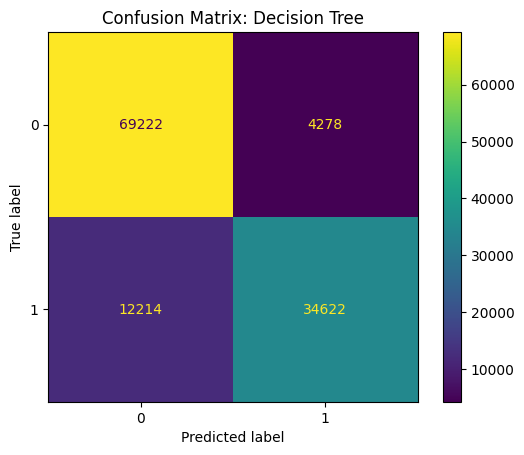

In [ ]:
ton_iot_dt_model = DecisionTreeClassifier(random_state=17)
ton_iot_dt_model.fit(ton_iot_X_train, ton_iot_y_train)
ton_iot_dt_pred = ton_iot_dt_model.predict(ton_iot_X_test)

print(classification_report(ton_iot_y_test, ton_iot_dt_pred))
ConfusionMatrixDisplay.from_estimator(ton_iot_dt_model, ton_iot_X_test, ton_iot_y_test)
plt.title('Confusion Matrix: Decision Tree')
plt.show()

#### Random Forest

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     73500
           1       0.90      0.74      0.81     46836

    accuracy                           0.87    120336
   macro avg       0.88      0.85      0.86    120336
weighted avg       0.87      0.87      0.87    120336



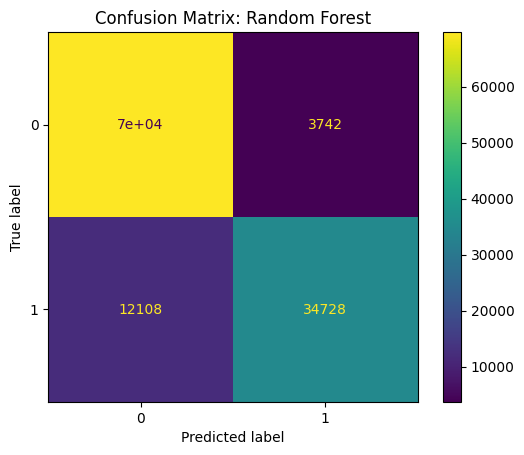

In [ ]:
ton_iot_rf_model = RandomForestClassifier(random_state=17)
ton_iot_rf_model.fit(ton_iot_X_train, ton_iot_y_train)
ton_iot_rf_pred = ton_iot_rf_model.predict(ton_iot_X_test)

print(classification_report(ton_iot_y_test, ton_iot_rf_pred))
ConfusionMatrixDisplay.from_estimator(ton_iot_rf_model, ton_iot_X_test, ton_iot_y_test)
plt.title('Confusion Matrix: Random Forest')
plt.show()

#### k-Nearest Neighbors (kNN)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86     73500
           1       0.80      0.74      0.77     46836

    accuracy                           0.83    120336
   macro avg       0.82      0.81      0.81    120336
weighted avg       0.83      0.83      0.82    120336



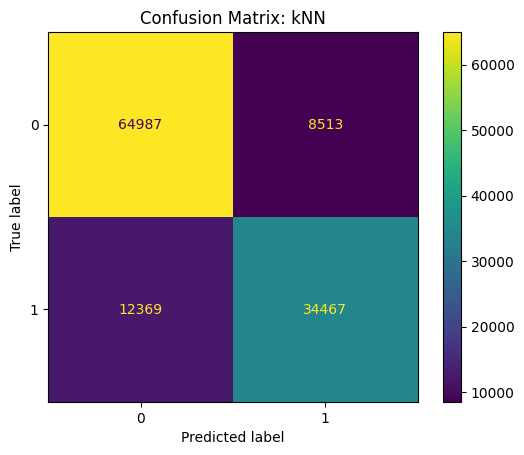

In [ ]:
ton_iot_knn_model = KNeighborsClassifier()
ton_iot_knn_model.fit(ton_iot_X_train_scaled, ton_iot_y_train)
ton_iot_knn_pred = ton_iot_knn_model.predict(ton_iot_X_test_scaled)

print(classification_report(ton_iot_y_test, ton_iot_knn_pred))
ConfusionMatrixDisplay.from_estimator(ton_iot_knn_model, ton_iot_X_test_scaled, ton_iot_y_test)
plt.title('Confusion Matrix: kNN')
plt.show()


#### Naive Bayes

              precision    recall  f1-score   support

           0       0.69      0.94      0.79     73500
           1       0.77      0.33      0.46     46836

    accuracy                           0.70    120336
   macro avg       0.73      0.63      0.63    120336
weighted avg       0.72      0.70      0.66    120336



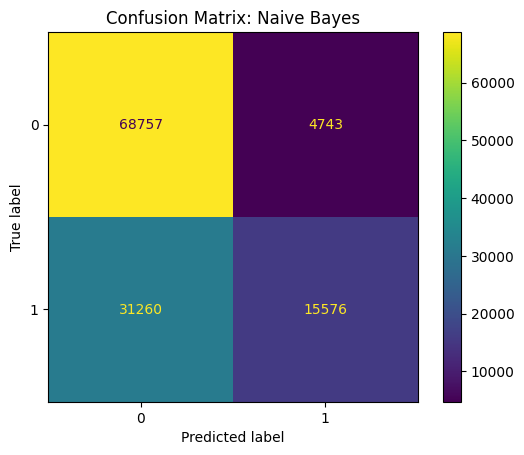

In [ ]:
ton_iot_nb_model = GaussianNB()
ton_iot_nb_model.fit(ton_iot_X_train, ton_iot_y_train)
ton_iot_nb_pred = ton_iot_nb_model.predict(ton_iot_X_test)

print(classification_report(ton_iot_y_test, ton_iot_nb_pred))
ConfusionMatrixDisplay.from_estimator(ton_iot_nb_model, ton_iot_X_test, ton_iot_y_test)
plt.title('Confusion Matrix: Naive Bayes')
plt.show()


#### Logistic Regression

              precision    recall  f1-score   support

           0       0.67      0.98      0.79     73500
           1       0.87      0.23      0.37     46836

    accuracy                           0.69    120336
   macro avg       0.77      0.61      0.58    120336
weighted avg       0.75      0.69      0.63    120336



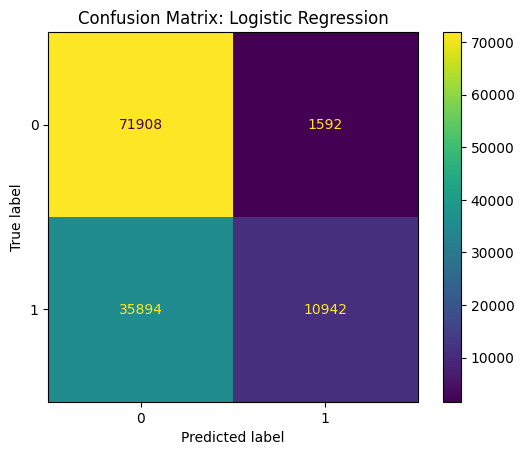

In [ ]:
ton_iot_lr_model = LogisticRegression(max_iter=500)
ton_iot_lr_model.fit(ton_iot_X_train_scaled, ton_iot_y_train)
ton_iot_lr_pred = ton_iot_lr_model.predict(ton_iot_X_test_scaled)

print(classification_report(ton_iot_y_test, ton_iot_lr_pred))
ConfusionMatrixDisplay.from_estimator(ton_iot_lr_model, ton_iot_X_test_scaled, ton_iot_y_test)
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

### Evaluation Report

#### Per-Class Performance

In [ ]:
ton_iot_attack_classes = ['Normal', 'Attack']  # Only 2 classes: 0 and 1

ton_iot_model_preds = [
    ('Decision Tree', ton_iot_dt_pred),
    ('Random Forest', ton_iot_rf_pred),
    ('kNN', ton_iot_knn_pred),
    ('Naive Bayes', ton_iot_nb_pred),
    ('Logistic Regression', ton_iot_lr_pred)
]

for model_name, preds in ton_iot_model_preds:
    precision, recall, f1, _ = precision_recall_fscore_support(
        ton_iot_y_test, preds, labels=[0, 1], zero_division=0  # Only labels 0 and 1
    )

    model_table = pd.DataFrame({
        'Attack Class': ton_iot_attack_classes,
        'Precision (%)': np.round(precision * 100, 2),
        'Recall (%)': np.round(recall * 100, 2),
        'F1-Score (%)': np.round(f1 * 100, 2)
    })

    print(f"\n<<<< {model_name} >>>>\n")
    display(model_table)


<<<< Decision Tree >>>>



,Attack Class,Precision (%),Recall (%),F1-Score (%)
0,Normal,85.0,94.18,89.36
1,Attack,89.0,73.92,80.76



<<<< Random Forest >>>>



,Attack Class,Precision (%),Recall (%),F1-Score (%)
0,Normal,85.21,94.91,89.80
1,Attack,90.27,74.15,81.42



<<<< kNN >>>>



,Attack Class,Precision (%),Recall (%),F1-Score (%)
0,Normal,84.01,88.42,86.16
1,Attack,80.19,73.59,76.75



<<<< Naive Bayes >>>>



,Attack Class,Precision (%),Recall (%),F1-Score (%)
0,Normal,68.75,93.55,79.25
1,Attack,76.66,33.26,46.39



<<<< Logistic Regression >>>>



,Attack Class,Precision (%),Recall (%),F1-Score (%)
0,Normal,66.7,97.83,79.32
1,Attack,87.3,23.36,36.86


In [ ]:
import pandas as pd
import plotly.express as px

# Data
f1_scores_ton_iot = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'kNN', 'Naive Bayes', 'Logistic Regression'],
    'Normal': [89.36, 89.80, 86.16, 79.25, 79.32],
    'Attack': [80.76, 81.42, 76.75, 46.39, 36.86]
})

# Melt the DataFrame for Plotly
f1_scores_melted = f1_scores_ton_iot.melt(
    id_vars='Model',
    var_name='Attack Class',
    value_name='F1-Score (%)'
)

# Plot
fig = px.bar(
    f1_scores_melted,
    x='Model',
    y='F1-Score (%)',
    color='Attack Class',
    barmode='group',
    text='F1-Score (%)',
    title="Comparison of Model F1-Scores for Normal and Attack Traffic",
    height=500
)

fig.update_layout(
    title_x=0.5,
    yaxis=dict(dtick=10, range=[0, 100]),
    bargap=0.3,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    )
)

fig.update_traces(textposition='outside')
fig.show()


#### Per-Model Overall Performance

In [ ]:
ton_iot_overall_results = []

ton_iot_model_full_preds = [
    ('Decision Tree', ton_iot_dt_pred),
    ('Random Forest', ton_iot_rf_pred),
    ('kNN', ton_iot_knn_pred),
    ('Naive Bayes', ton_iot_nb_pred),
    ('Logistic Regression', ton_iot_lr_pred)
]

for model_name, preds in ton_iot_model_full_preds:
    ton_iot_overall_results.append({
        'Algorithm': model_name,
        'Accuracy (%)': round(accuracy_score(ton_iot_y_test, preds) * 100, 2),
        'Precision (%)': round(precision_score(ton_iot_y_test, preds, average='macro', zero_division=0) * 100, 2),
        'Recall (%)': round(recall_score(ton_iot_y_test, preds, average='macro', zero_division=0) * 100, 2),
        'F1-Score (%)': round(f1_score(ton_iot_y_test, preds, average='macro', zero_division=0) * 100, 2)
    })

ton_iot_overall_summary = pd.DataFrame(ton_iot_overall_results)

print("\n<<<< Overall Model Performance Summary (TON IoT) >>>>")
display(ton_iot_overall_summary)



<<<< Overall Model Performance Summary (TON IoT) >>>>


,Algorithm,Accuracy (%),Precision (%),Recall (%),F1-Score (%)
0,Decision Tree,86.30,87.00,84.05,85.06
1,Random Forest,86.83,87.74,84.53,85.61
2,kNN,82.65,82.10,81.00,81.45
3,Naive Bayes,70.08,72.70,63.40,62.82
4,Logistic Regression,68.85,77.00,60.60,58.09


In [ ]:
import plotly.express as px

# Create interactive bar plot for TON IoT
fig = px.bar(
    ton_iot_overall_summary,
    x='Algorithm',
    y='Accuracy (%)',
    title='Accuracy Comparison Across Algorithms (TON IoT Dataset)',
    text='Accuracy (%)',
    range_y=[60, 90]
)

# Customize the layout
fig.update_layout(
    yaxis=dict(dtick=5),  # y-tick every 5%
    xaxis_title='Algorithm',
    yaxis_title='Accuracy (%)',
    title_x=0.5,  # Center the title
    bargap=0.4
)

# Show interactive plot
fig.show()

#### Comparison with Benchmark Data

In [ ]:
import pandas as pd
import plotly.express as px

# 1. Prepare the comparison data
comparison_data = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'kNN', 'Naive Bayes', 'Logistic Regression'],
    'This Study Accuracy (%)': [86.30, 86.83, 82.65, 70.08, 68.85],
    'Benchmark Accuracy (%)': [88, 85, 84, 61, 61],
    'This Study F1-Score (%)': [85.06, 85.61, 81.45, 62.40, 58.09],
    'Benchmark F1-Score (%)': [88, 85, 84, 46, 46]
})

# 2. Plot Accuracy Comparison
accuracy_data = comparison_data.melt(
    id_vars='Model',
    value_vars=['This Study Accuracy (%)', 'Benchmark Accuracy (%)'],
    var_name='Source',
    value_name='Accuracy (%)'
)

fig_accuracy = px.bar(
    accuracy_data,
    x='Model',
    y='Accuracy (%)',
    color='Source',
    barmode='group',
    text='Accuracy (%)',
    title="Accuracy Comparison Across Models: This Study vs. Benchmark (TON_IoT)",
    height=500
)

fig_accuracy.update_layout(
    title_x=0.5,
    yaxis=dict(dtick=5, range=[50, 100]),
    bargap=0.3,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    )
)

fig_accuracy.update_traces(textposition='outside')
fig_accuracy.show()

# 3. Plot F1-Score Comparison
f1_data = comparison_data.melt(
    id_vars='Model',
    value_vars=['This Study F1-Score (%)', 'Benchmark F1-Score (%)'],
    var_name='Source',
    value_name='F1-Score (%)'
)

fig_f1 = px.bar(
    f1_data,
    x='Model',
    y='F1-Score (%)',
    color='Source',
    barmode='group',
    text='F1-Score (%)',
    title="F1-Score Comparison Across Models: This Study vs. Benchmark (TON_IoT)",
    height=500
)

fig_f1.update_layout(
    title_x=0.5,
    yaxis=dict(dtick=5, range=[30, 100]),
    bargap=0.3,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    )
)

fig_f1.update_traces(textposition='outside')
fig_f1.show()
